In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#分類問題
from sklearn.svm import SVC

from sklearn import metrics

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
iris_dataset = load_iris()

X_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = pd.DataFrame(iris_dataset.data, columns=X_columns)

y = pd.DataFrame(iris_dataset.target, columns=["Species"])

df_iris = pd.concat([X, y], axis=1)

df = df_iris.query("Species == [0, 1]").loc[:, ["petal_length", "petal_width", "Species"]]
df.head()

,petal_length,petal_width,Species
0,1.4,0.2,0
1,1.4,0.2,0
2,1.3,0.2,0
3,1.5,0.2,0
4,1.4,0.2,0


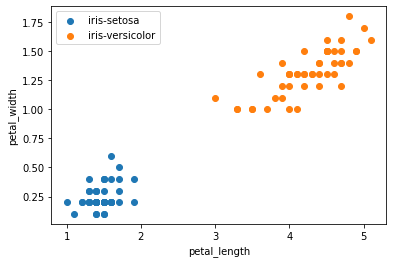

In [3]:
plt.scatter(df[(df['Species'] == 0).values]['petal_length'],
            df[(df['Species'] == 0).values]['petal_width'],
            label = 'iris-setosa',
            cmap = 'viridis')

plt.scatter(df[(df['Species'] == 1).values]['petal_length'],
            df[(df['Species'] == 1).values]['petal_width'],
            label = 'iris-versicolor',
            cmap = 'viridis')

plt.xlabel('petal_length')
plt.ylabel('petal_width')
plt.legend()
plt.show()

In [4]:
X = df.iloc[:, [0, 1]].values
y = df.iloc[:, 2].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3) 

- 前処理・標準化

In [5]:
scaler = StandardScaler()

In [6]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [7]:
X_train_scaled = scaler.transform(X_train)

In [8]:
X_test_scaled = scaler.transform(X_test)

In [9]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル

    """
    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
    
    def __transform_y(self, y):
        """
        訓練用yの値を-1, 1に変換する関数
        """
        self.y_one = y.max()
        self.y_minus_one = y.min()
        
        return np.where(y == self.y_one, 1, -1)[:, np.newaxis]

    def __transform_y_val(self, y):
        """
        検証用yの値を-1, 1に変換する関数
        """
        self.y_one_val = y.max()
        self.y_minus_one_val = y.min()
        
        return np.where(y == self.y_one_val, 1, -1)[:, np.newaxis]
    
    def __kernel_function(self, X_i, X_j):
        """
        カーネル関数
        """
        if self.kernel == 'linear':
            K = np.dot(X_i, X_j.T)  

        return K              
        
    def __lagrange_multipliers_method(self, X, y, K):
        """
        訓練用ラグランジュの未定乗数法
        識別境界からの距離が最小となる点がSupport Vectorを構成する。
        """
        updated_lambda = self.lambda_ + self.lr * (1 - np.dot((np.dot(y, y.T) * K), self.lambda_))
        updated_lambda = np.where(updated_lambda >= 0, updated_lambda, 0)

        return updated_lambda

    def __lagrange_multipliers_method_val(self, X, y, K):
        """
        検証用ラグランジュの未定乗数法
        識別境界からの距離が最小となる点がSupport Vectorを構成する。
        """
        updated_lambda_val = self.lambda_val + self.lr * (1 - np.dot((np.dot(y, y.T) * K), self.lambda_val))
        updated_lambda_val = np.where(updated_lambda_val >= 0, updated_lambda_val, 0)

        return updated_lambda_val
    
    def __determine_support_vector(self, X, y):
        """
        訓練用サポートベクターを決定し、それに関する情報を保持する。
        """       
        self.index_support_vectors = np.where(self.lambda_ > self.threshold)[0]
        self.n_support_vectors = len(self.index_support_vectors)
        self.X_sv = X[self.index_support_vectors]
        self.y_sv = y[self.index_support_vectors]
        self.lam_sv = self.lambda_[self.index_support_vectors]

    def __determine_support_vector_val(self, X, y):
        """
        検証用サポートベクターを決定し、それに関する情報を保持する。
        """       
        self.index_support_vectors_val = np.where(self.lambda_val > self.threshold)[0]
        self.n_support_vectors_val = len(self.index_support_vectors_val)
        self.X_sv_val = X[self.index_support_vectors_val]
        self.y_sv_val = y[self.index_support_vectors_val]
        self.lam_sv_val = self.lambda_val[self.index_support_vectors_val]
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """        
        y = self.__transform_y(y)
        self.lambda_ = np.random.rand(X.shape[0])[:, np.newaxis]

        if not(X_val is None) and not(y_val is None):
            y_val = self.__transform_y_val(y_val)
            self.lambda_val = np.random.rand(X_val.shape[0])[:, np.newaxis]        
        
        for epoch in range(self.iter):
            K = self.__kernel_function(X, X)
            self.lambda_ = self.__lagrange_multipliers_method(X, y, K)
            self.__determine_support_vector(X, y)

            if not(X_val is None) and not(y_val is None):
                K = self.__kernel_function(X_val, X_val)
                self.lambda_val = self.__lagrange_multipliers_method_val(X_val, y_val, K)
                self.__determine_support_vector_val(X_val, y_val)                
            
            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                print("Epoch {}".format(epoch + 1) + "*"*40 )
                print("Number of support vectors:{}".format(self.n_support_vectors))
                if not(X_val is None) and not(y_val is None):
                    print("Epoch {}".format(epoch + 1) + "*"*40 )
                    print("Number of support vectors val:{}".format(self.n_support_vectors_val))
    
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        classified_result = np.dot(self.__kernel_function(X, self.X_sv), (self.y_sv * self.lam_sv)).flatten()
        classified_result = np.where(classified_result >= 0, 1, -1)
        classified_result = np.where(classified_result == classified_result.max(), self.y_one, self.y_minus_one)
        
        return classified_result

### 【問題1】ラグランジュの未定乗数法による最急降下
SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 $\lambda$ を用意して、以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。

$$
\lambda_{i}^{new}=\lambda_{i}+\alpha(1-\displaystyle \sum_{j=1}^n
\lambda_{j}y_{i}y_{j}k(x_{i},x_{j}))
$$

ここで $k(x_i, x_j)$ はカーネル関数です。線形カーネルの場合は次のようになります。他のカーネル関数にも対応できるように、この部分は独立したメソッドとしておきましょう。

$$
k(x_{i},x_{j})=x_{i}^{T}x_{j}
$$


条件として、更新毎に $\lambda_i >= 0$を満たす必要があります。満たさない場合は $\lambda_i = 0$とします。


$i, j$ : サンプルのインデックス


$\lambda_i^{new}$ : 更新後のi番目のサンプルのラグランジュ乗数


$\lambda_i$ : 更新前のi番目のサンプルのラグランジュ乗数


$\alpha$ : 学習率


$\lambda_j$ : j番目のサンプルのラグランジュ乗数


$y_i$ : i番目のサンプルのラベル


$y_j$ : j番目のサンプルのラベル


$x_i$ : i番目のサンプルの特徴量ベクトル


$x_j$ : j番目のサンプルの特徴量ベクトル


あるサンプルに対しての全てのサンプルとの関係を計算していくことになります。

### 【問題2】サポートベクターの決定
計算したラグランジュ乗数 $\lambda$ が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。


閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。

### 【問題3】推定
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた $f(x)$ の符号が分類結果です。

$$
f(x)=\displaystyle \sum_{n=1}^N
\lambda_{n}y_{sv_n}k(x,s_{n})
$$


$x$ : 推定したいデータの特徴量ベクトル


$N$ : サポートベクターの数


$n$ : サポートベクターのインデックス


$\lambda_n$ : $n$番目のサポートベクターのラグランジュ乗数


$y_{sv_n}$ : $n$番目のサポートベクターのラベル


$k()$ : カーネル関数


$s_n$ : $n$番目のサポートベクターの特徴量

In [10]:
model = ScratchSVMClassifier(num_iter=1000, lr=0.001, kernel='linear', threshold=1e-5, verbose=True) #0.00001
model.fit(X_train_scaled, y_train.ravel(), X_test_scaled, y_test.ravel())

Epoch 1****************************************
Number of support vectors:67
Epoch 1****************************************
Number of support vectors val:27
Epoch 2****************************************
Number of support vectors:64
Epoch 2****************************************
Number of support vectors val:26
Epoch 3****************************************
Number of support vectors:60
Epoch 3****************************************
Number of support vectors val:25
Epoch 4****************************************
Number of support vectors:58
Epoch 4****************************************
Number of support vectors val:25
Epoch 5****************************************
Number of support vectors:55
Epoch 5****************************************
Number of support vectors val:24
Epoch 6****************************************
Number of support vectors:50
Epoch 6****************************************
Number of support vectors val:24
Epoch 7****************************************
Numb

Epoch 338****************************************
Number of support vectors:7
Epoch 338****************************************
Number of support vectors val:9
Epoch 339****************************************
Number of support vectors:7
Epoch 339****************************************
Number of support vectors val:9
Epoch 340****************************************
Number of support vectors:7
Epoch 340****************************************
Number of support vectors val:9
Epoch 341****************************************
Number of support vectors:7
Epoch 341****************************************
Number of support vectors val:9
Epoch 342****************************************
Number of support vectors:7
Epoch 342****************************************
Number of support vectors val:9
Epoch 343****************************************
Number of support vectors:7
Epoch 343****************************************
Number of support vectors val:9
Epoch 344*******************************

Epoch 532****************************************
Number of support vectors:6
Epoch 532****************************************
Number of support vectors val:7
Epoch 533****************************************
Number of support vectors:6
Epoch 533****************************************
Number of support vectors val:7
Epoch 534****************************************
Number of support vectors:6
Epoch 534****************************************
Number of support vectors val:7
Epoch 535****************************************
Number of support vectors:6
Epoch 535****************************************
Number of support vectors val:7
Epoch 536****************************************
Number of support vectors:6
Epoch 536****************************************
Number of support vectors val:7
Epoch 537****************************************
Number of support vectors:6
Epoch 537****************************************
Number of support vectors val:7
Epoch 538*******************************

Epoch 859****************************************
Number of support vectors:6
Epoch 859****************************************
Number of support vectors val:5
Epoch 860****************************************
Number of support vectors:6
Epoch 860****************************************
Number of support vectors val:5
Epoch 861****************************************
Number of support vectors:6
Epoch 861****************************************
Number of support vectors val:5
Epoch 862****************************************
Number of support vectors:6
Epoch 862****************************************
Number of support vectors val:5
Epoch 863****************************************
Number of support vectors:6
Epoch 863****************************************
Number of support vectors val:5
Epoch 864****************************************
Number of support vectors:6
Epoch 864****************************************
Number of support vectors val:5
Epoch 865*******************************

In [11]:
y_pred = model.predict(X_test_scaled)
y_pred

array([1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1])

In [12]:
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train.ravel())
svm_pred = svm_model.predict(X_test_scaled)

In [13]:
svm_pred

array([1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1])

### 【問題4】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

#### シンプルデータセット1

In [14]:
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)
random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

- 前処理・訓練データと検証データの分割

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3)

- 前処理・標準化

In [16]:
scaler = StandardScaler()

In [17]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
X_train_scaled = scaler.transform(X_train)

In [19]:
X_test_scaled = scaler.transform(X_test)

__scikit-learn SVM__

In [20]:
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train.ravel())
svm_pred = svm_model.predict(X_test_scaled)

In [21]:
def evaluate(y_true, y_pred):
    """
    2値分類の評価指標を計算・描画する。
    """
    acc = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    
    plt.figure(figsize=(1.6, 1.2))
    cm_def = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_def, annot=True, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    return acc, precision, recall, f1

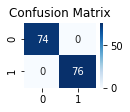

Accuracy : 1.00
Precision : 1.00
Recall : 1.00
F1 : 1.00



In [22]:
print('Accuracy : {:.2f}\n'
      'Precision : {:.2f}\n'
      'Recall : {:.2f}\n'
      'F1 : {:.2f}\n'
      .format(*evaluate(y_test, svm_pred)))

__scratch SVM__

In [23]:
model = ScratchSVMClassifier(num_iter=1000, lr=0.001, kernel='linear', threshold=1e-5, verbose=True) #0.00001
model.fit(X_train_scaled, y_train.ravel())
y_pred = model.predict(X_test_scaled)

Epoch 1****************************************
Number of support vectors:250
Epoch 2****************************************
Number of support vectors:210
Epoch 3****************************************
Number of support vectors:188
Epoch 4****************************************
Number of support vectors:159
Epoch 5****************************************
Number of support vectors:142
Epoch 6****************************************
Number of support vectors:129
Epoch 7****************************************
Number of support vectors:118
Epoch 8****************************************
Number of support vectors:113
Epoch 9****************************************
Number of support vectors:106
Epoch 10****************************************
Number of support vectors:101
Epoch 11****************************************
Number of support vectors:93
Epoch 12****************************************
Number of support vectors:89
Epoch 13****************************************
Number of supp

Epoch 141****************************************
Number of support vectors:20
Epoch 142****************************************
Number of support vectors:20
Epoch 143****************************************
Number of support vectors:20
Epoch 144****************************************
Number of support vectors:20
Epoch 145****************************************
Number of support vectors:20
Epoch 146****************************************
Number of support vectors:20
Epoch 147****************************************
Number of support vectors:20
Epoch 148****************************************
Number of support vectors:20
Epoch 149****************************************
Number of support vectors:20
Epoch 150****************************************
Number of support vectors:20
Epoch 151****************************************
Number of support vectors:20
Epoch 152****************************************
Number of support vectors:20
Epoch 153****************************************
Nu

Epoch 295****************************************
Number of support vectors:22
Epoch 296****************************************
Number of support vectors:22
Epoch 297****************************************
Number of support vectors:22
Epoch 298****************************************
Number of support vectors:22
Epoch 299****************************************
Number of support vectors:21
Epoch 300****************************************
Number of support vectors:21
Epoch 301****************************************
Number of support vectors:21
Epoch 302****************************************
Number of support vectors:21
Epoch 303****************************************
Number of support vectors:21
Epoch 304****************************************
Number of support vectors:21
Epoch 305****************************************
Number of support vectors:21
Epoch 306****************************************
Number of support vectors:21
Epoch 307****************************************
Nu

Epoch 459****************************************
Number of support vectors:21
Epoch 460****************************************
Number of support vectors:21
Epoch 461****************************************
Number of support vectors:21
Epoch 462****************************************
Number of support vectors:21
Epoch 463****************************************
Number of support vectors:21
Epoch 464****************************************
Number of support vectors:21
Epoch 465****************************************
Number of support vectors:21
Epoch 466****************************************
Number of support vectors:21
Epoch 467****************************************
Number of support vectors:21
Epoch 468****************************************
Number of support vectors:21
Epoch 469****************************************
Number of support vectors:21
Epoch 470****************************************
Number of support vectors:21
Epoch 471****************************************
Nu

Epoch 622****************************************
Number of support vectors:19
Epoch 623****************************************
Number of support vectors:19
Epoch 624****************************************
Number of support vectors:19
Epoch 625****************************************
Number of support vectors:19
Epoch 626****************************************
Number of support vectors:19
Epoch 627****************************************
Number of support vectors:19
Epoch 628****************************************
Number of support vectors:19
Epoch 629****************************************
Number of support vectors:19
Epoch 630****************************************
Number of support vectors:19
Epoch 631****************************************
Number of support vectors:19
Epoch 632****************************************
Number of support vectors:19
Epoch 633****************************************
Number of support vectors:19
Epoch 634****************************************
Nu

Number of support vectors:16
Epoch 790****************************************
Number of support vectors:16
Epoch 791****************************************
Number of support vectors:16
Epoch 792****************************************
Number of support vectors:16
Epoch 793****************************************
Number of support vectors:16
Epoch 794****************************************
Number of support vectors:16
Epoch 795****************************************
Number of support vectors:16
Epoch 796****************************************
Number of support vectors:16
Epoch 797****************************************
Number of support vectors:16
Epoch 798****************************************
Number of support vectors:16
Epoch 799****************************************
Number of support vectors:16
Epoch 800****************************************
Number of support vectors:16
Epoch 801****************************************
Number of support vectors:16
Epoch 802**************

Epoch 954****************************************
Number of support vectors:14
Epoch 955****************************************
Number of support vectors:14
Epoch 956****************************************
Number of support vectors:14
Epoch 957****************************************
Number of support vectors:14
Epoch 958****************************************
Number of support vectors:14
Epoch 959****************************************
Number of support vectors:14
Epoch 960****************************************
Number of support vectors:14
Epoch 961****************************************
Number of support vectors:14
Epoch 962****************************************
Number of support vectors:14
Epoch 963****************************************
Number of support vectors:14
Epoch 964****************************************
Number of support vectors:14
Epoch 965****************************************
Number of support vectors:14
Epoch 966****************************************
Nu

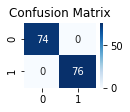

Accuracy : 1.00
Precision : 1.00
Recall : 1.00
F1 : 1.00



In [24]:
print('Accuracy : {:.2f}\n'
      'Precision : {:.2f}\n'
      'Recall : {:.2f}\n'
      'F1 : {:.2f}\n'
      .format(*evaluate(y_test, y_pred)))

### 【問題5】決定領域の可視化
決定領域を可視化してください。


以下の例のようにサポートベクターは異なる色で示してください。

In [25]:
def decision_region(X, y, model, step=0.01, title='decision region',
                    xlabel='f0', ylabel='f1', target_names=['0', '1']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5,
                                              np.max(X[:,0])+0.5, step),
                                    np.arange(np.min(X[:,1])-0.5,
                                              np.max(X[:,1])+0.5, step))

    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80,
                    color=scatter_color[i], label=target_names[i], marker='o')
        if hasattr(model, 'y_sv') and model.y_sv.size != 0:
            plt.scatter(model.X_sv[model.y_sv.flatten()==target][:, 0], model.X_sv[model.y_sv.flatten()==target][:, 1], s=80,
                        color="yellow", marker='o')            
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

__scratch SVM__

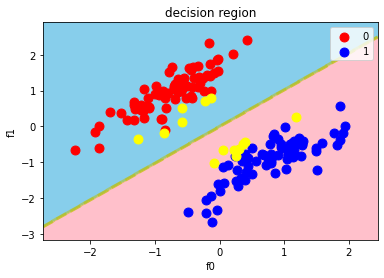

In [26]:
decision_region(X_test_scaled, y_pred, model)

__scikit-learn SVM__

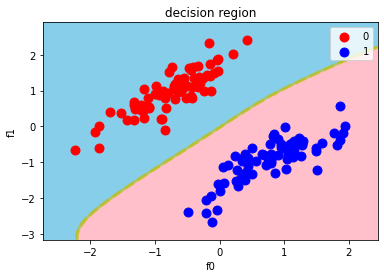

In [27]:
decision_region(X_test_scaled, svm_pred, svm_model)